# Example - Chicago Crime

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-target" data-toc-modified-id="Create-a-target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a target</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Domain classifier</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from models.aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/olist/"
PREFIX = "olist"

In [5]:
orders = pd.read_csv(DATASETS_PATH + "olist_orders_dataset.csv", engine="python")
customers = pd.read_csv(DATASETS_PATH + "olist_customers_dataset.csv", engine="python")
reviews = pd.read_csv(DATASETS_PATH + "olist_order_reviews_dataset.csv", engine="python")
payments = pd.read_csv(DATASETS_PATH + "olist_order_payments_dataset.csv", engine="python")
products = pd.read_csv(DATASETS_PATH + "olist_products_dataset.csv", engine="python")
category = pd.read_csv(DATASETS_PATH + "product_category_name_translation.csv", engine="python")
items = pd.read_csv(DATASETS_PATH + "olist_order_items_dataset.csv", engine="python")

In [6]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [7]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at).dt.date  
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date  
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date  
items['shipping_limit_date'] = pd.to_datetime(items.shipping_limit_date).dt.date  

In [8]:
data = orders.merge(reviews, on="order_id", how="left")

In [9]:
data = data.merge(items, on="order_id", how="left")
data = data.merge(products, on="product_id", how="left") 

In [10]:
data["Year"] = data["order_purchase_timestamp"].apply(lambda x: int(x.year))
data["Year-month"] = data["order_purchase_timestamp"].apply(lambda x: str(x.year) + "-" + str(x.month).zfill(2))
data["Year-trimester"] = data["order_purchase_timestamp"].apply(lambda x: str(x.year) + "-" + str(int(x.month / 3)).zfill(2))

In [11]:
data.shape

(114100, 31)

In [12]:
data.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                  611
order_delivered_carrier_date     81018
order_delivered_customer_date      645
order_estimated_delivery_date      459
review_id                        99173
review_score                         5
review_comment_title              4600
review_comment_message           36921
review_creation_date               637
review_answer_timestamp          99010
order_item_id                       21
product_id                       32951
seller_id                         3095
shipping_limit_date                555
price                             5968
freight_value                     6999
product_category_name               73
product_name_lenght                 66
product_description_lenght        2960
product_photos_qty                  19
product_weight_g                  2204
product_length_cm        

In [13]:
data.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
review_id                                object
review_score                              int64
review_comment_title                     object
review_comment_message                   object
review_creation_date                     object
review_answer_timestamp                  object
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
product_category_name                   

## Create target

In [14]:
data["review_score"].unique()

array([4, 5, 2, 1, 3])

In [15]:
data["target"] = (data["review_score"] == 5).astype(int)

In [16]:
data["target"].mean()

0.5582646801051709

## Modeling

### Data

In [17]:
TIME_COLUMN = "Year-month"
ALTERNATIVE_TIME_COLUMN = "Year-trimester"
TARGET = "target"

In [18]:
data["difference_estimated_delivered"] = (data['order_estimated_delivery_date'] - data['order_delivered_customer_date']).dt.days
data["difference_limit_delivered"] = (data['shipping_limit_date'] - data['order_delivered_customer_date']).dt.days

In [19]:
columns_to_label_encode = ["seller_id",
                           "product_category_name"]

In [20]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

seller_id
product_category_name


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [21]:
numerical_features = ["price",
                      "freight_value",
                      "product_name_lenght",
                      "product_description_lenght", 
                      "product_photos_qty", 
                      "product_weight_g",
                      "product_length_cm",
                      "product_height_cm", 
                      "product_width_cm",
                      "difference_estimated_delivered",
                      "difference_limit_delivered"]

In [22]:
features = columns_to_label_encode + numerical_features
features = list(set(features))

In [23]:
data["Year"].value_counts()

2018    61912
2017    51796
2016      392
Name: Year, dtype: int64

In [24]:
data = data[~data["Year"].isin([2016])]

In [25]:
data["Year"].value_counts()

2018    61912
2017    51796
Name: Year, dtype: int64

In [26]:
training_start_year = 2017
training_end_year = 2017
holdout_end_year = 2018

In [27]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [28]:
out_of_time = out_of_time[~out_of_time[TIME_COLUMN].isin(["2018-10", "2018-09"])]

In [29]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [30]:
train.shape

(41436, 34)

In [31]:
test.shape

(10360, 34)

In [32]:
out_of_time.shape

(61892, 34)

In [33]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Checking the support in the different environments

In [34]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2017    1.0
Name: seller_id, dtype: float64
Year
2017    1.0
Name: product_category_name, dtype: float64


1.0

In [35]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

Year-month
2017-01    0.555556
2017-02    0.555556
2017-03    0.666667
2017-04    0.777778
2017-05    0.666667
2017-06    0.555556
2017-07    0.444444
2017-08    0.555556
2017-09    0.333333
2017-10    0.555556
2017-11    0.555556
2017-12    0.555556
Name: price_quant, dtype: float64
Year-month
2017-01    0.4
2017-02    0.6
2017-03    0.7
2017-04    0.7
2017-05    0.9
2017-06    0.8
2017-07    0.7
2017-08    0.7
2017-09    0.7
2017-10    0.7
2017-11    0.9
2017-12    0.6
Name: freight_value_quant, dtype: float64
Year-month
2017-01    0.8
2017-02    0.8
2017-03    0.9
2017-04    0.8
2017-05    0.9
2017-06    0.8
2017-07    1.0
2017-08    1.0
2017-09    1.0
2017-10    0.9
2017-11    0.9
2017-12    1.0
Name: product_name_lenght_quant, dtype: float64
Year-month
2017-01    1.0
2017-02    1.0
2017-03    1.0
2017-04    1.0
2017-05    1.0
2017-06    1.0
2017-07    1.0
2017-08    1.0
2017-09    1.0
2017-10    1.0
2017-11    1.0
2017-12    1.0
Name: product_description_lenght_quant, dtype: float


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.8224747474747475

### Benchmark

In [36]:
from pycaret.classification import *

In [37]:
TARGET

'target'

In [38]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [39]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [40]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [41]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt"]))

0.7201808700855554
0.6490132357210412
0.6367836349299378


In [42]:
benchmark_model = RandomForestClassifier(n_estimators=100, max_depth=8)
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [43]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.696117293449354
0.6402814757846313
0.63480694226314


In [44]:
# benchmark_importances = benchmark_model.feature_importances_
# benchmark_importances = pd.Series(benchmark_importances, index=features)
# benchmark_importances.rename("RF", inplace=True)

price                             0.044696
product_name_lenght               0.025439
difference_estimated_delivered    0.321944
product_description_lenght        0.036234
product_category_name             0.057346
product_weight_g                  0.035588
product_height_cm                 0.030004
difference_limit_delivered        0.264553
seller_id                         0.044902
product_photos_qty                0.010073
product_length_cm                 0.036732
product_width_cm                  0.024115
freight_value                     0.068373
Name: RF, dtype: float64

In [45]:
results = reverse_learning_curve(train, out_of_time, tuned_rf, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5)

In [ ]:
benchmark_importances = results["feature_importance"][-1].rename("RF", inplace=True)

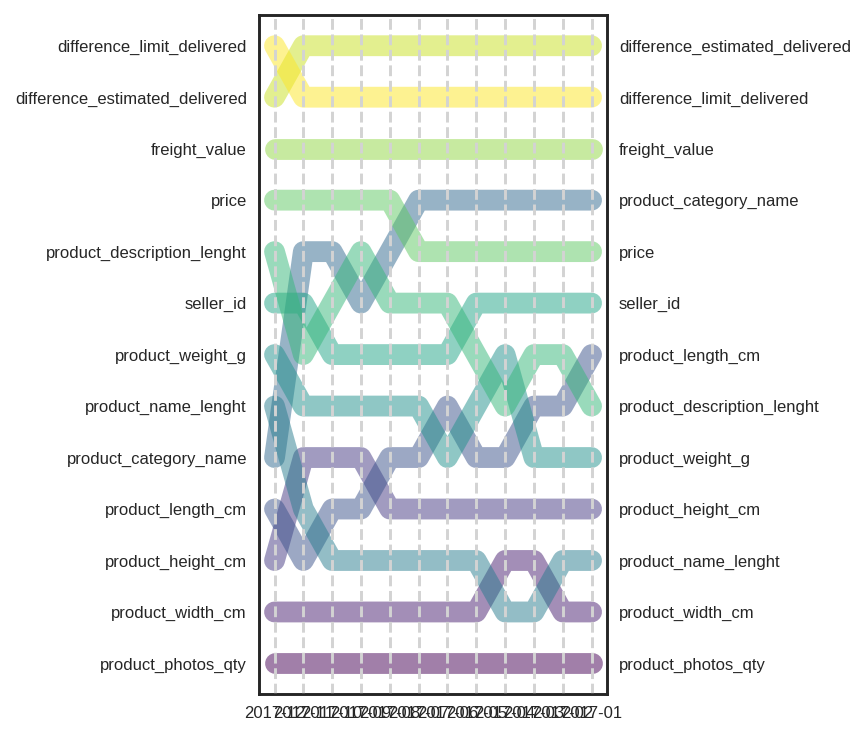

In [46]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

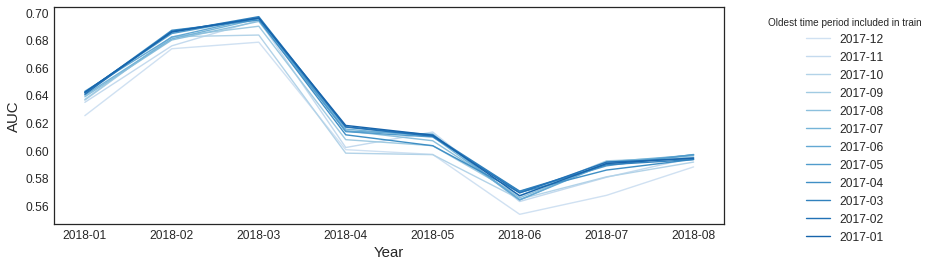

In [47]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [48]:
results

{'round': [],
 'holdout_performance': [0.6201968736417193,
  0.62917771786716,
  0.6260393200155476,
  0.6318284966670347,
  0.6338093611580442,
  0.6349801826690891,
  0.6354782853370046,
  0.6358412287438349,
  0.6339732584160194,
  0.6365747649617981,
  0.6365112034678374,
  0.6367836349299378],
 'feature_importance': [price                             0.074225
  product_name_lenght               0.057908
  difference_estimated_delivered    0.174565
  product_description_lenght        0.069169
  product_category_name             0.053632
  product_weight_g                  0.058617
  product_height_cm                 0.051413
  difference_limit_delivered        0.195501
  seller_id                         0.065388
  product_photos_qty                0.021876
  product_length_cm                 0.052454
  product_width_cm                  0.042720
  freight_value                     0.082532
  Name: 2017-12, dtype: float64,
  price                             0.060648
  product_name_

## Challenger model

In [49]:
train.reset_index(drop=True, inplace=True)

In [50]:
train[features + [TIME_COLUMN]]

price  product_name_lenght  difference_estimated_delivered  \
0      267.99                 51.0                            24.0   
1       49.90                 44.0                            19.0   
2      129.90                 53.0                             9.0   
3       14.50                 56.0                             8.0   
4      199.90                 59.0                            15.0   
...       ...                  ...                             ...   
41431   89.00                 35.0                            27.0   
41432   40.00                 30.0                            11.0   
41433  213.00                 28.0                            15.0   
41434   56.99                 54.0                            24.0   
41435   59.90                 63.0                            17.0   

       product_description_lenght  product_category_name  product_weight_g  \
0                          2025.0                     45             350.0   
1                           368.0                     13             756.0   
2                           220.0                     54            1000.0   
3                           351.0                     71             350.0   
4                           302.0                     15            3800.0   
...                           ...                    ...               ...   
41431                       920.0                     34             100.0   
41432                       227.0                     34             200.0   
41433                       855.0                     10            1000.0   
41434                      1536.0                     63             250.0   
41435                       785.0                     64             800.0   

       product_height_cm  difference_limit_delivered  seller_id  \
0                    5.0                         5.0        510   
1                   21.0                        -6.0       1330   
2                   30.0                         1.0       1113   
3                    4.0                       -10.0       1798   
4                   15.0                        -6.0        881   
...                  ...                         ...        ...   
41431                2.0                         7.0        604   
41432                8.0                         3.0        468   
41433               10.0                        -4.0        961   
41434                8.0                        -1.0       2482   
41435                4.0                        -4.0       1333   

       product_photos_qty  product_length_cm  product_width_cm  freight_value  \
0                     2.0               20.0              20.0          15.63   
1                     3.0               32.0              24.0          15.70   
2                     3.0               20.0              20.0           9.72   
3                     1.0               19.0              11.0          15.10   
4                     2.0               45.0              35.0          26.24   
...                   ...                ...               ...            ...   
41431                 7.0               20.0              25.0          17.90   
41432                 2.0               16.0              11.0           7.78   
41433                 2.0               30.0              25.0          18.74   
41434                 2.0               20.0              21.0          14.15   
41435                 1.0               38.0              19.0          11.81   

      Year-month  
0        2017-08  
1        2017-02  
2        2017-08  
3        2017-06  
4        2017-09  
...          ...  
41431    2017-12  
41432    2017-06  
41433    2017-06  
41434    2017-11  
41435    2017-02  

[41436 rows x 14 columns]

In [51]:
train["Year"].value_counts()

2017    41436
Name: Year, dtype: int64

In [52]:
train[TIME_COLUMN].nunique()

12

In [53]:
CHALLENGER_MAX_DEPTH = 11
CHALLENGER_N_ESTIMATORS = 250
CHALLENGER_MIN_SAMPLES_BY_PERIODS = 2

In [54]:
challenger_model_max = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        period_criterion='max',
                                        multi=True)

challenger_model_max.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

In [55]:
train["challenger_prediction_max"] = challenger_model_max.predict_proba(train[features])[:, 1]
test["challenger_prediction_max"] = challenger_model_max.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_max"] = challenger_model_max.predict_proba(out_of_time[features])[:, 1]

In [56]:
print(roc_auc_score(train[TARGET], train["challenger_prediction_max"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_max"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_max"]))

0.6589422170308075
0.6258530815198137
0.6270696031984664


In [57]:
challenger_model_max.feature_importance()

challenger_model_max_importances = challenger_model_max.feature_importance()
challenger_model_max_importances.rename("TRF Max", inplace=True)

product_description_lenght        2535
freight_value                     2495
price                             2481
seller_id                         2322
difference_limit_delivered        2287
product_weight_g                  2084
product_length_cm                 1977
product_name_lenght               1939
product_height_cm                 1918
product_category_name             1855
product_width_cm                  1704
difference_estimated_delivered    1625
product_photos_qty                 830
Name: TRF Max, dtype: int64

In [58]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [59]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.6602220360533511
0.6261660981216891
0.6272887071728751


## Feature Importance migration

In [ ]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)

results_trt = reverse_learning_curve(train, out_of_time, challenger_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, trt_model=True)

In [ ]:
challenger_model_importances = results_trt["feature_importance"][-1].rename("TRF", inplace=True)

In [60]:
challenger_model_importances = challenger_model.feature_importance()
challenger_model_importances.rename("TRF", inplace=True)
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)
# all_models_importance = all_models_importance.merge(challenger_model_max_importances, how="left", left_index=True, 
#                             right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

RF   TRF  TRF Max
price                           0.044696  2517     2481
product_name_lenght             0.025439  1949     1939
difference_estimated_delivered  0.321944  1626     1625
product_description_lenght      0.036234  2546     2535
product_category_name           0.057346  1798     1855
product_weight_g                0.035588  2134     2084
product_height_cm               0.030004  1881     1918
difference_limit_delivered      0.264553  2283     2287
seller_id                       0.044902  2314     2322
product_photos_qty              0.010073   837      830
product_length_cm               0.036732  1935     1977
product_width_cm                0.024115  1773     1704
freight_value                   0.068373  2512     2495

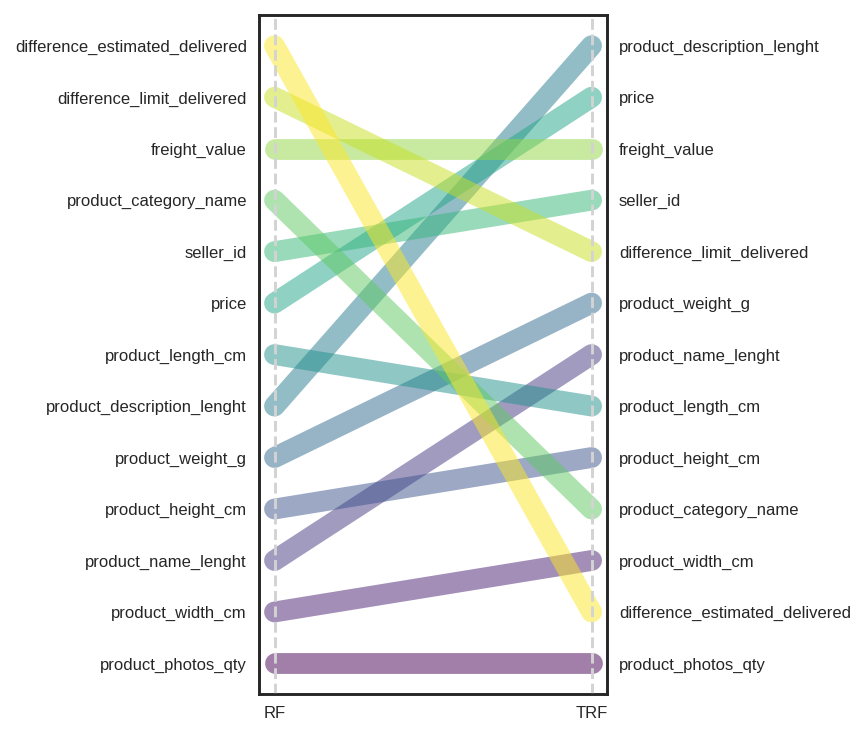

In [61]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

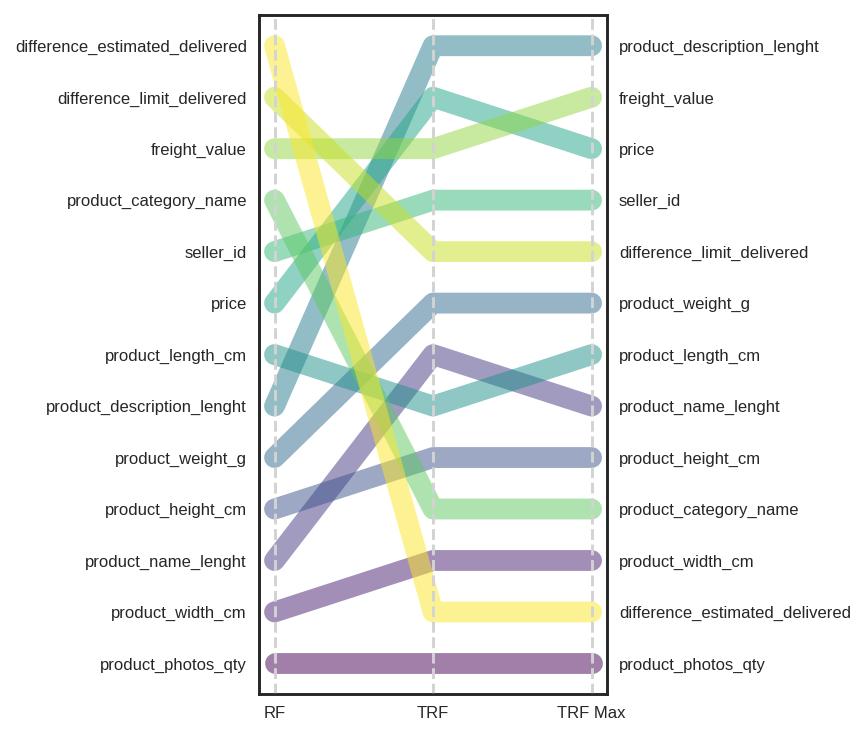

In [62]:
# plot_shap_difference(all_models_importance, title="", save_as="../images/{}_importance_migration_trf_max.eps".format(PREFIX))

## Reverse Learning Curve

2017-12  2017-11  2017-10  2017-09  2017-08  \
price                              6765     7873     5926     5283     5177   
product_name_lenght                5546     6267     4707     4234     3983   
difference_estimated_delivered     5799     6906     5343     5022     4728   
product_description_lenght         5927     6938     5630     5216     5046   
product_category_name              4193     4951     4137     3619     3613   
product_weight_g                   5070     6240     5185     4667     4488   
product_height_cm                  4128     5349     4488     3992     3892   
difference_limit_delivered         5252     6360     5191     4873     4649   
seller_id                          4565     5916     5137     4885     4586   
product_photos_qty                 1999     2627     2205     2031     1897   
product_length_cm                  3488     4617     4178     3777     3777   
product_width_cm                   3295     4495     4115     3805     3550   
freight_value                      4710     6587     5886     5621     5158   

                                2017-07  2017-06  2017-05  2017-04  2017-03  \
price                              4745     4092     4104     4194     3960   
product_name_lenght                3809     3252     3210     3138     3082   
difference_estimated_delivered     4391     3843     3885     3843     3749   
product_description_lenght         4678     3981     4167     4066     3928   
product_category_name              3386     2870     2901     2910     2788   
product_weight_g                   4197     3639     3674     3558     3540   
product_height_cm                  3611     3004     3080     3038     2893   
difference_limit_delivered         4194     3784     3866     3739     3660   
seller_id                          4154     3841     3660     3596     3661   
product_photos_qty                 1646     1378     1399     1417     1349   
product_length_cm                  3501     3056     3112     3205     2999   
product_width_cm                   3332     2960     2942     2872     2776   
freight_value                      4923     4386     4421     4155     4041   

                                2017-02  2017-01  
price                              3565     2526  
product_name_lenght                2824     1936  
difference_estimated_delivered     3104     1626  
product_description_lenght         3706     2573  
product_category_name              2537     1814  
product_weight_g                   3113     2094  
product_height_cm                  2720     1977  
difference_limit_delivered         3383     2314  
seller_id                          3317     2399  
product_photos_qty                 1252      845  
product_length_cm                  2834     1863  
product_width_cm                   2705     1808  
freight_value                      3791     2475

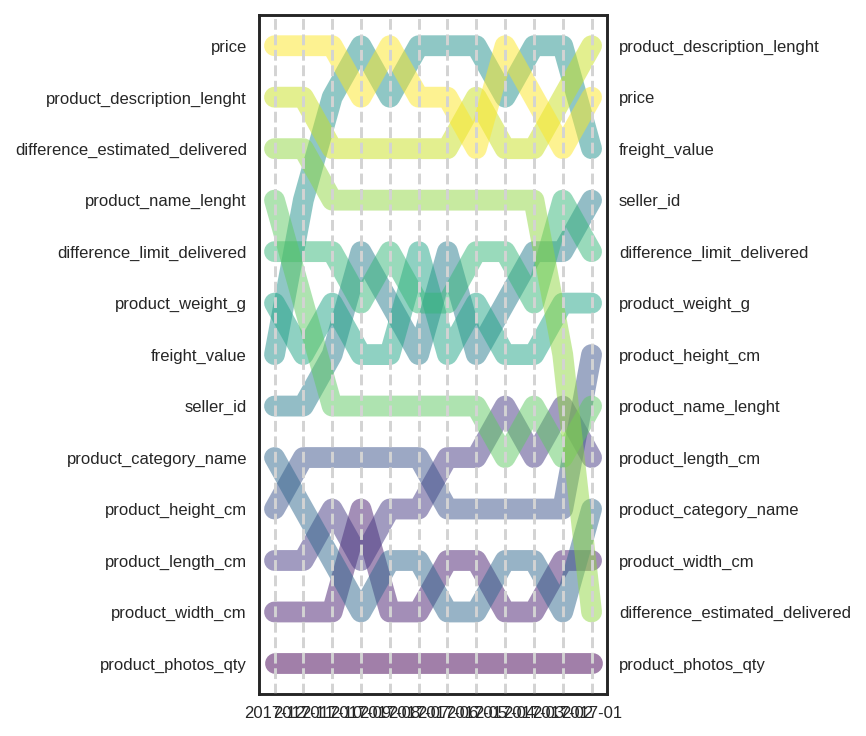

In [65]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

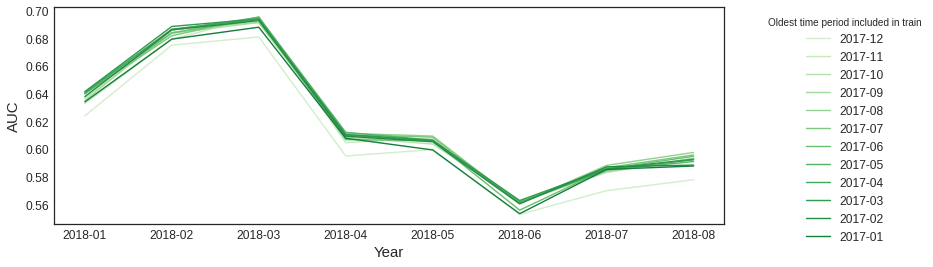

In [66]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

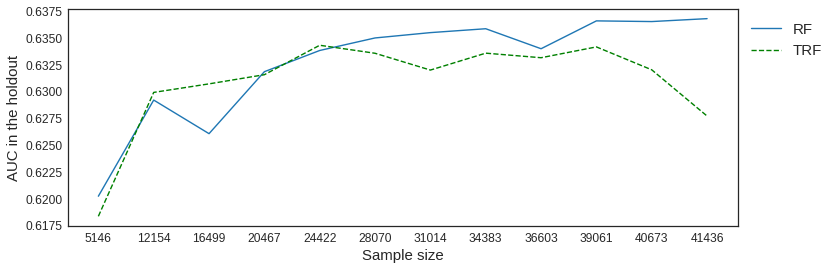

In [67]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

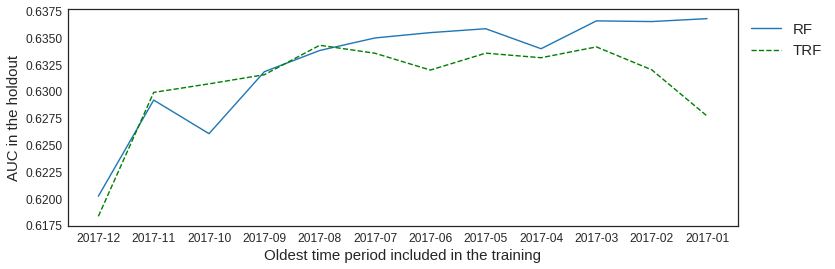

In [68]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

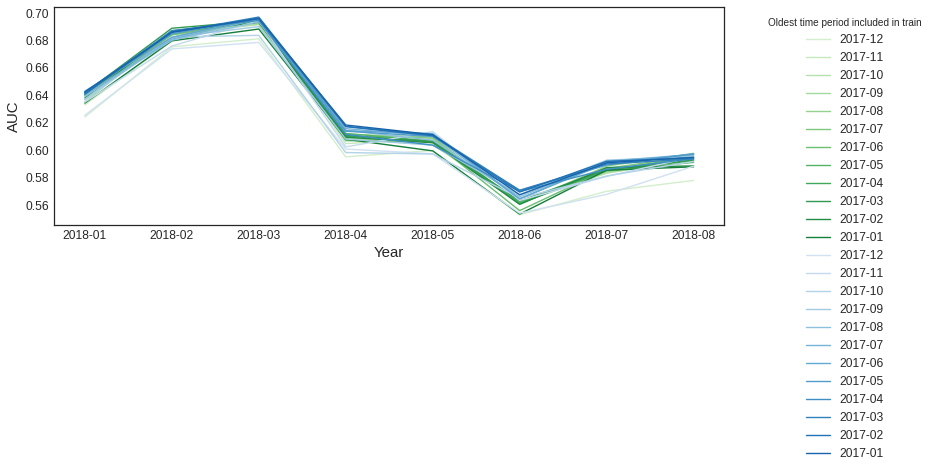

In [69]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

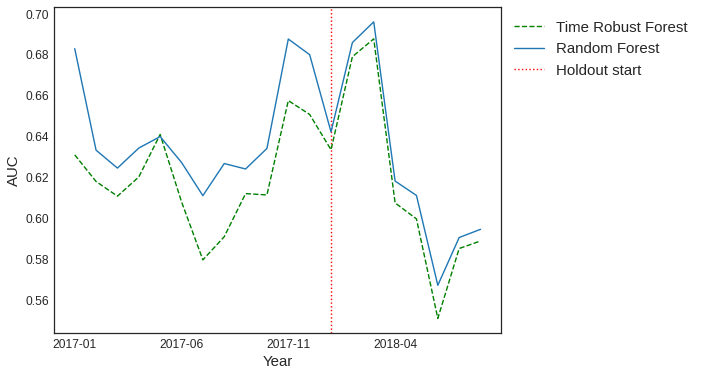

In [137]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

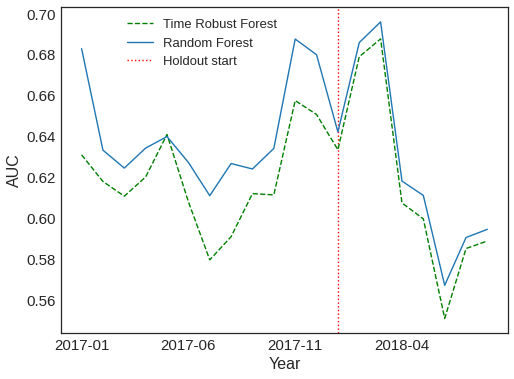

In [136]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
#plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, bbox_to_anchor=(0.12, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [72]:
challenger_model.feature_importance()

product_description_lenght        2573
price                             2526
freight_value                     2475
seller_id                         2399
difference_limit_delivered        2314
product_weight_g                  2094
product_height_cm                 1977
product_name_lenght               1936
product_length_cm                 1863
product_category_name             1814
product_width_cm                  1808
difference_estimated_delivered    1626
product_photos_qty                 845
Name: Feature Importance, dtype: int64

In [73]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['price',
 'product_name_lenght',
 'difference_estimated_delivered',
 'product_description_lenght',
 'product_category_name',
 'product_weight_g',
 'product_height_cm',
 'difference_limit_delivered',
 'seller_id',
 'product_photos_qty',
 'product_length_cm',
 'product_width_cm',
 'freight_value']

In [74]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['product_description_lenght',
 'price',
 'freight_value',
 'seller_id',
 'difference_limit_delivered',
 'product_weight_g',
 'product_height_cm',
 'product_name_lenght']

In [75]:
selected_features

['product_description_lenght',
 'price',
 'freight_value',
 'seller_id',
 'difference_limit_delivered',
 'product_weight_g',
 'product_height_cm',
 'product_name_lenght']

In [76]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [77]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [78]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [79]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.7142840290509116
0.6432216175647806
0.6310546004876286


In [132]:
train[TIME_COLUMN].nunique()

12

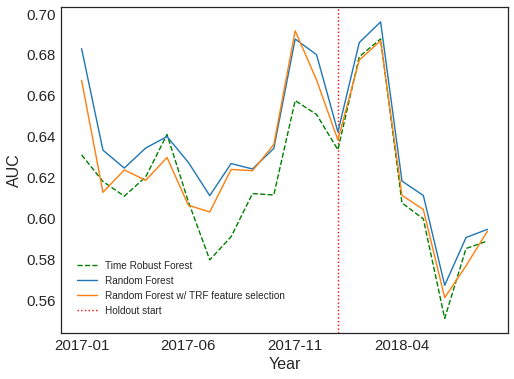

In [133]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="Random Forest w/ TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=10, bbox_to_anchor=(0.52, 0.25))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [81]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

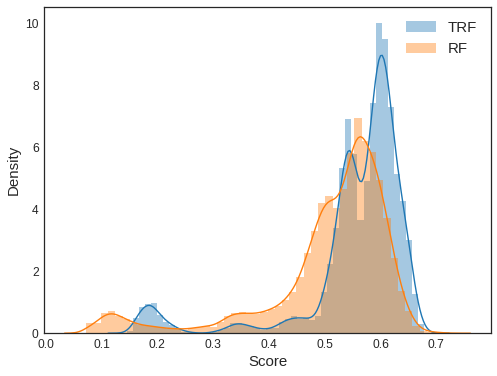

In [82]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction_opt"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [83]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction_opt"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

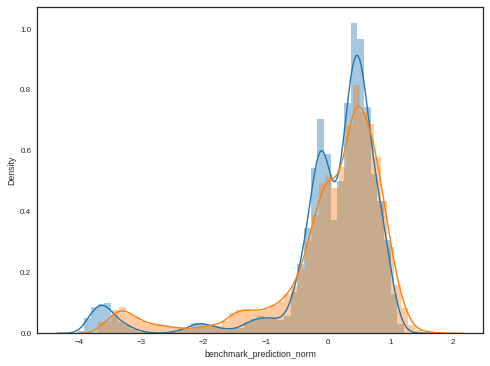

In [84]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [85]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(24756, 13)
(37136, 13)


In [86]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['price',
 'product_name_lenght',
 'difference_estimated_delivered',
 'product_description_lenght',
 'product_weight_g',
 'product_height_cm',
 'difference_limit_delivered',
 'product_photos_qty',
 'product_length_cm',
 'product_width_cm',
 'freight_value']

In [87]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [88]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (11 of 11) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


In [89]:
pred_test = gam_challenger.predict(X_test[features])
print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

pred_test = gam_benchmark.predict(X_test[features])
print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

r2 test (challenger): 0.950948
r2 test (benchmark): 0.913679


price
0


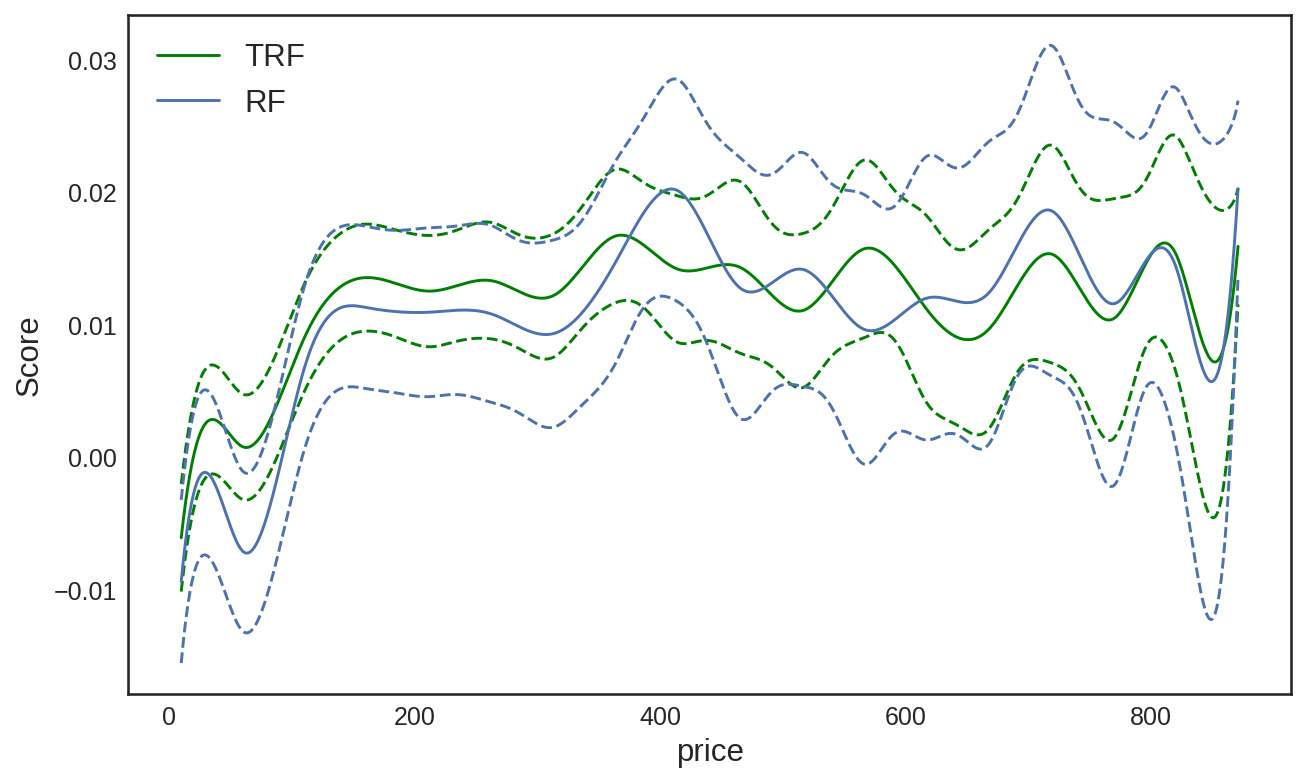

product_name_lenght
1


<Figure size 576x432 with 0 Axes>

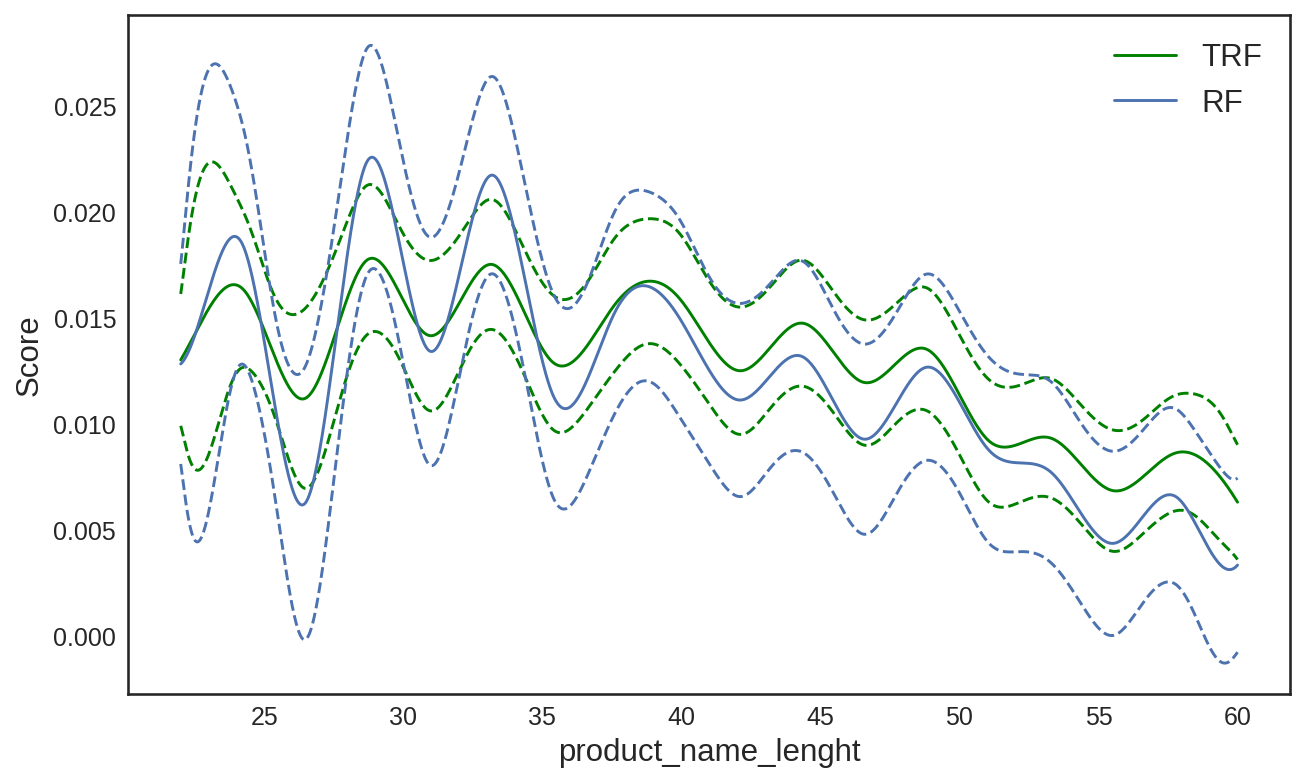

difference_estimated_delivered
2


<Figure size 576x432 with 0 Axes>

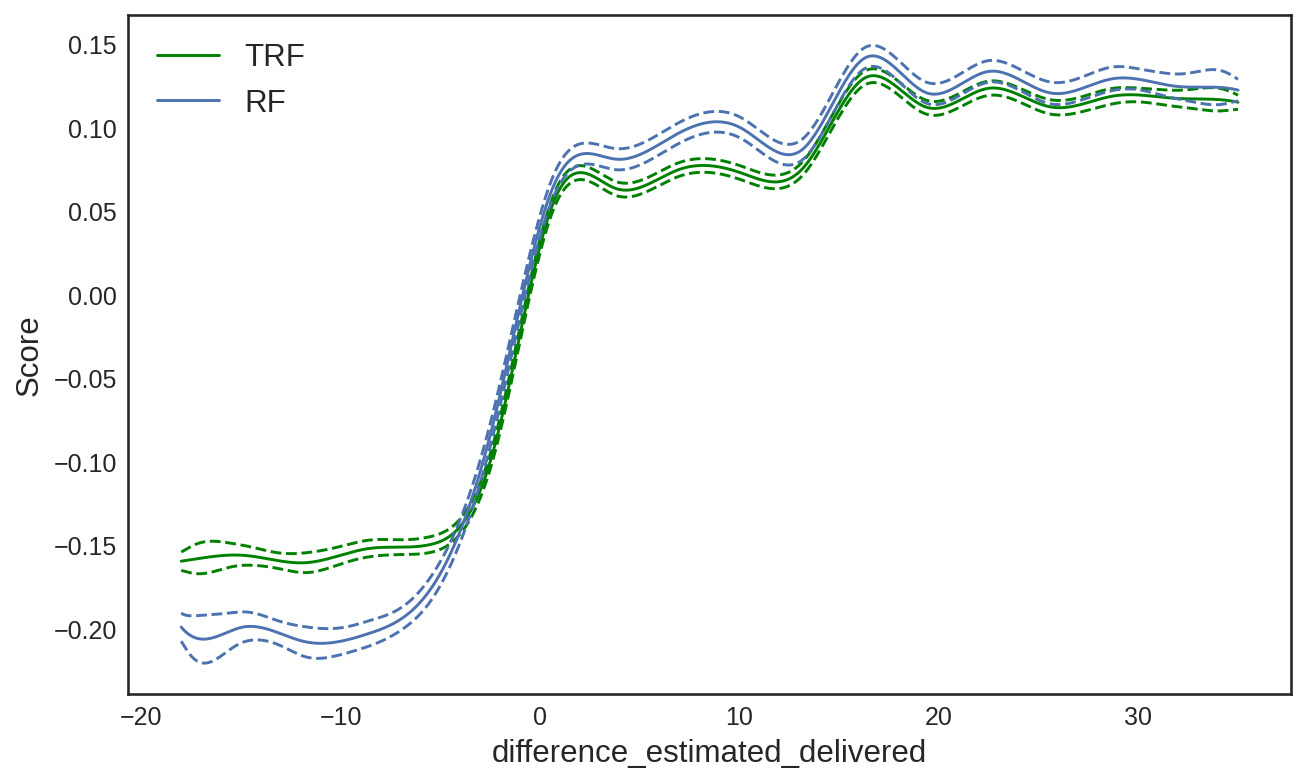

product_description_lenght
3


<Figure size 576x432 with 0 Axes>

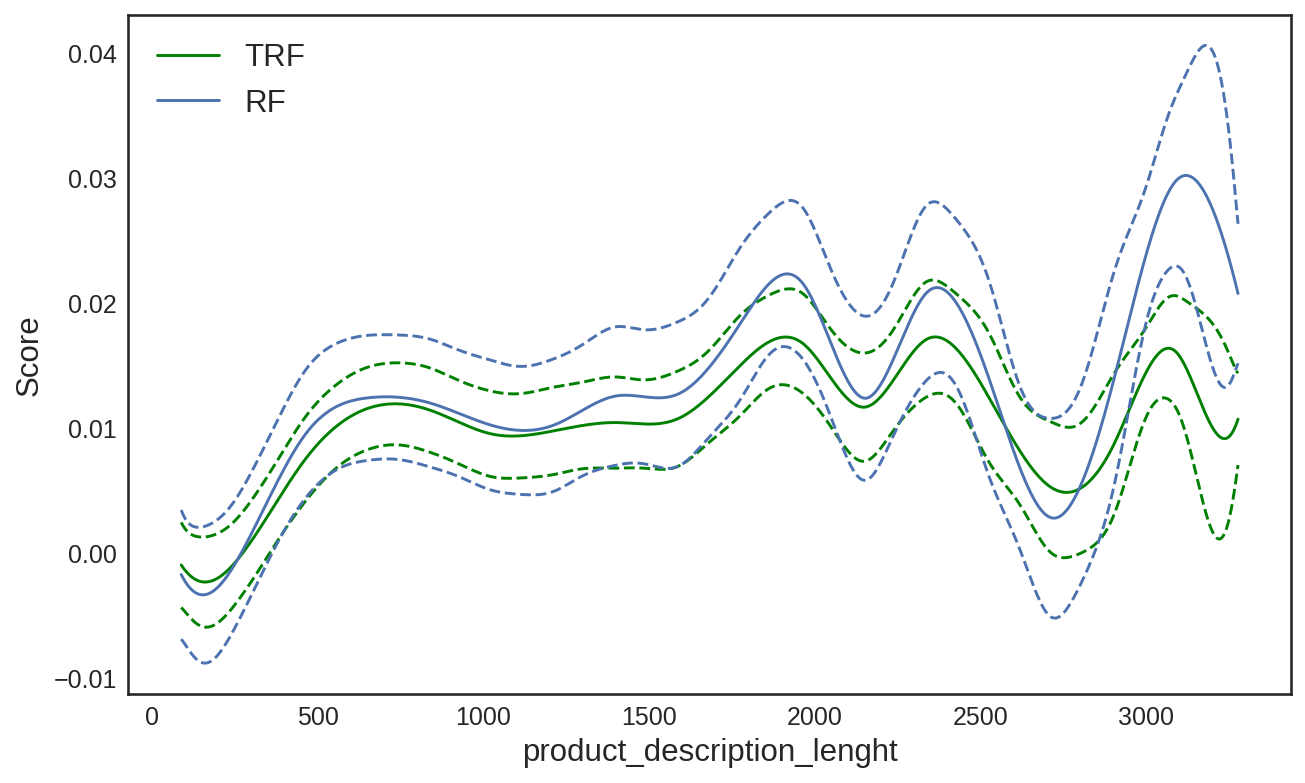

product_weight_g
5


<Figure size 576x432 with 0 Axes>

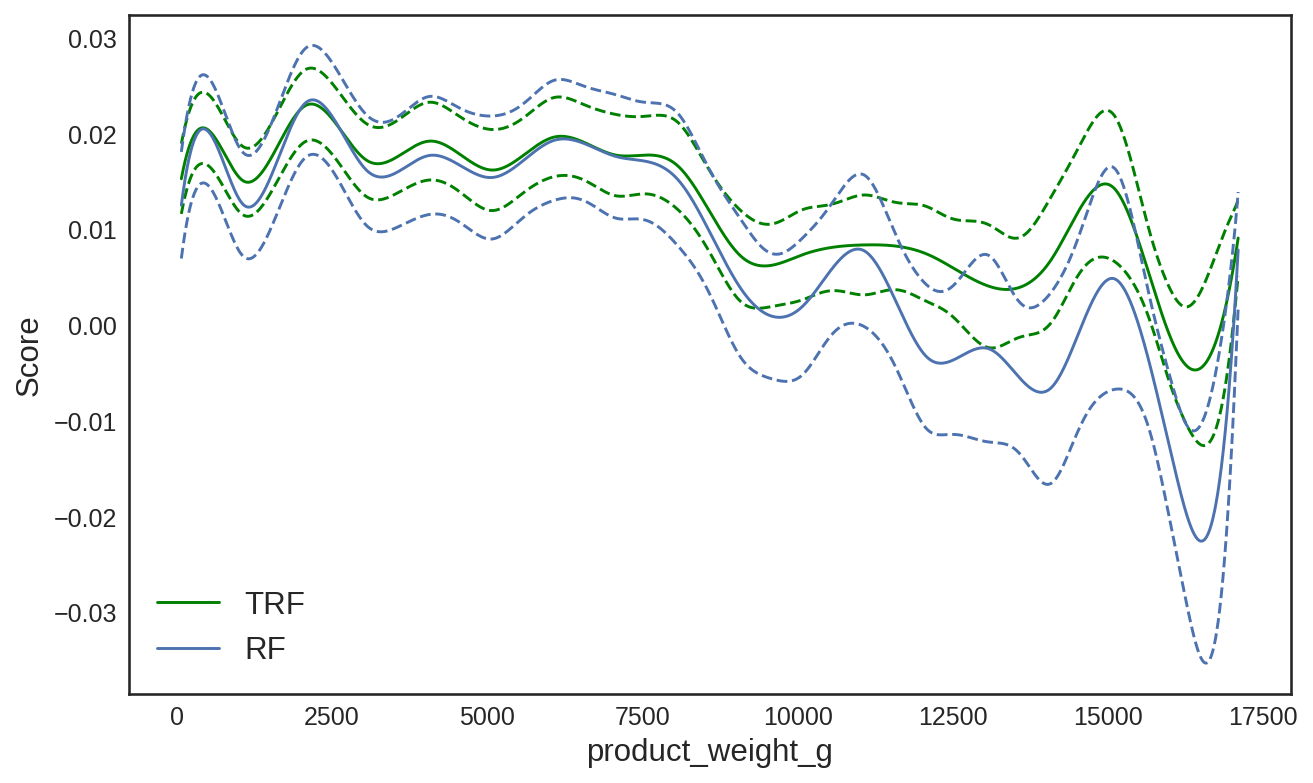

product_height_cm
6


<Figure size 576x432 with 0 Axes>

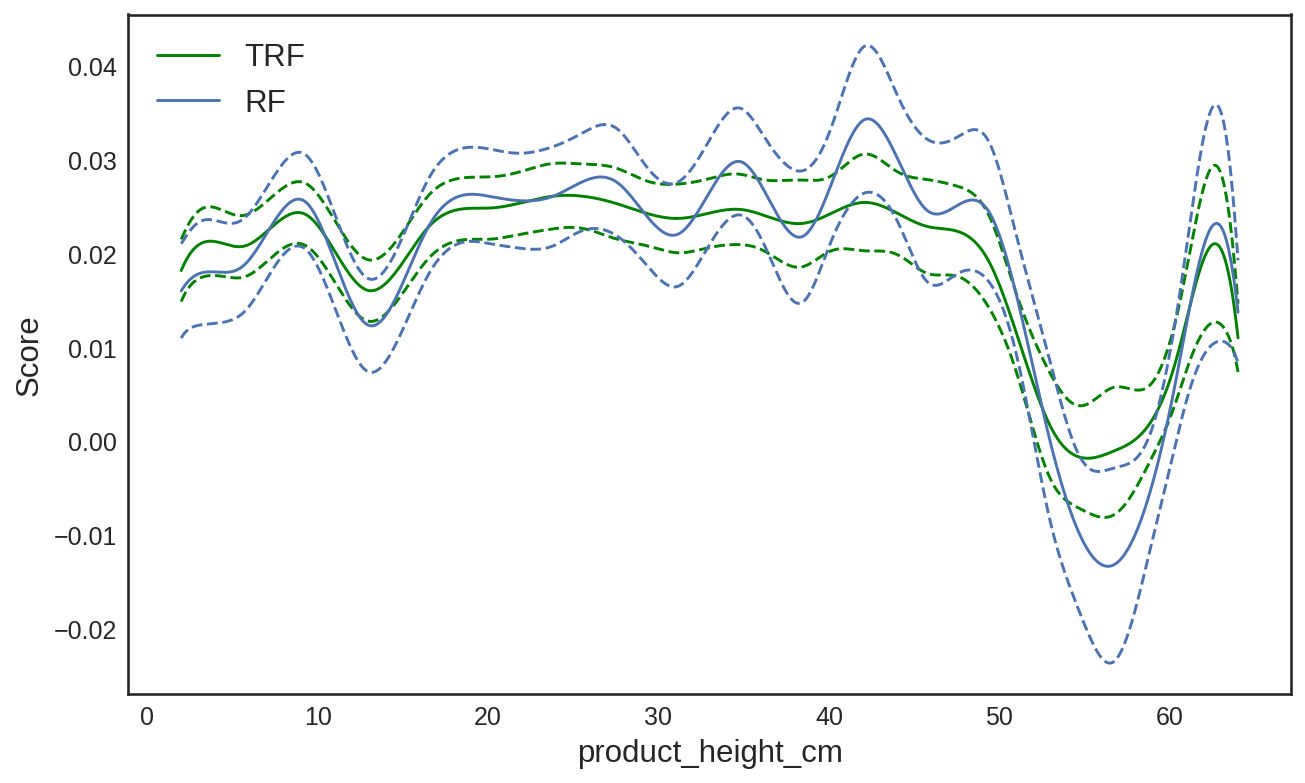

difference_limit_delivered
7


<Figure size 576x432 with 0 Axes>

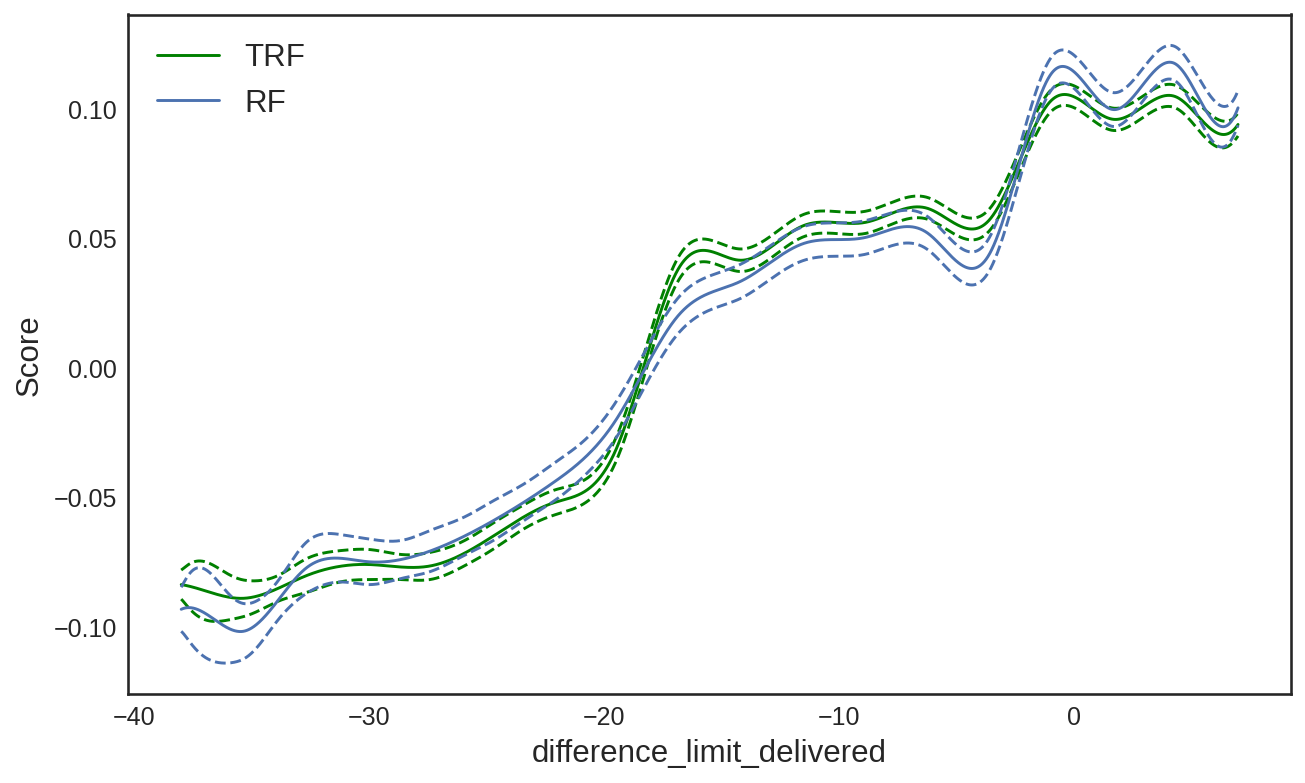

product_photos_qty
9


<Figure size 576x432 with 0 Axes>

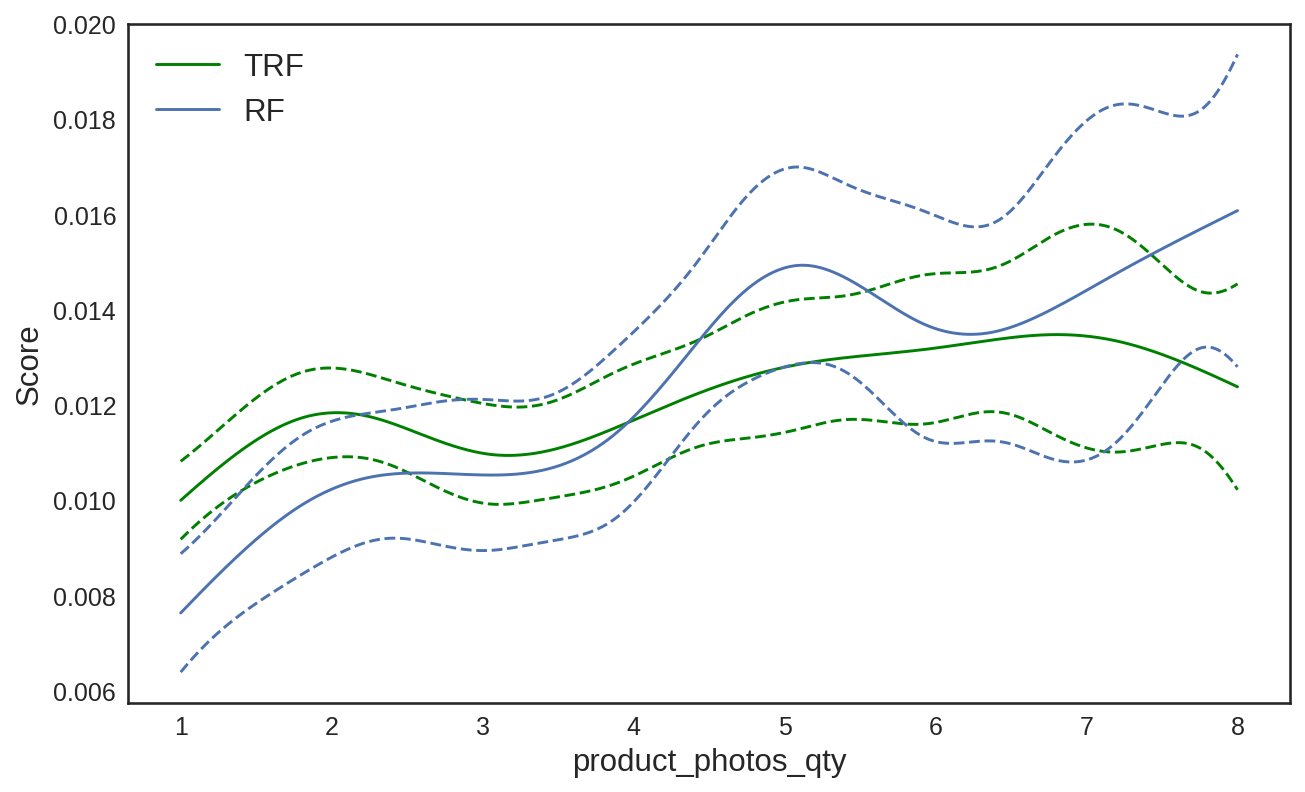

product_length_cm
10


<Figure size 576x432 with 0 Axes>

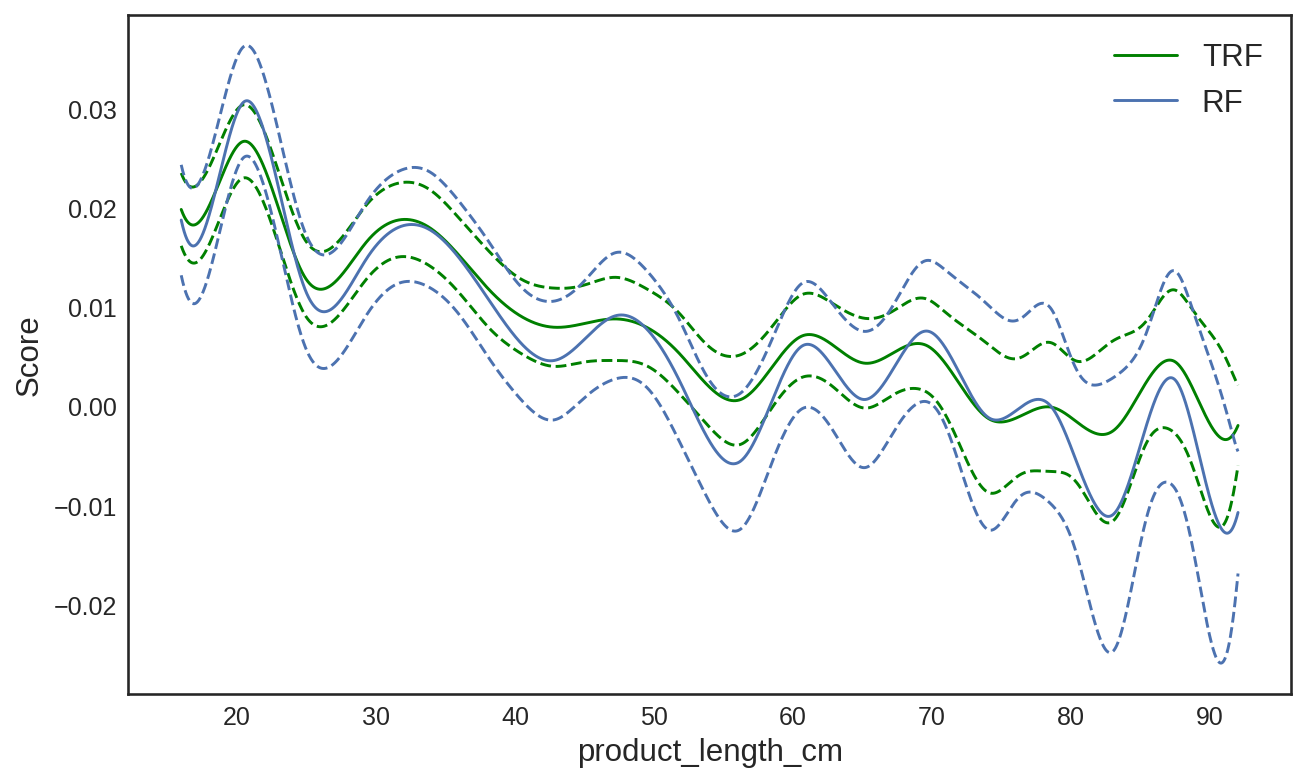

product_width_cm
11


<Figure size 576x432 with 0 Axes>

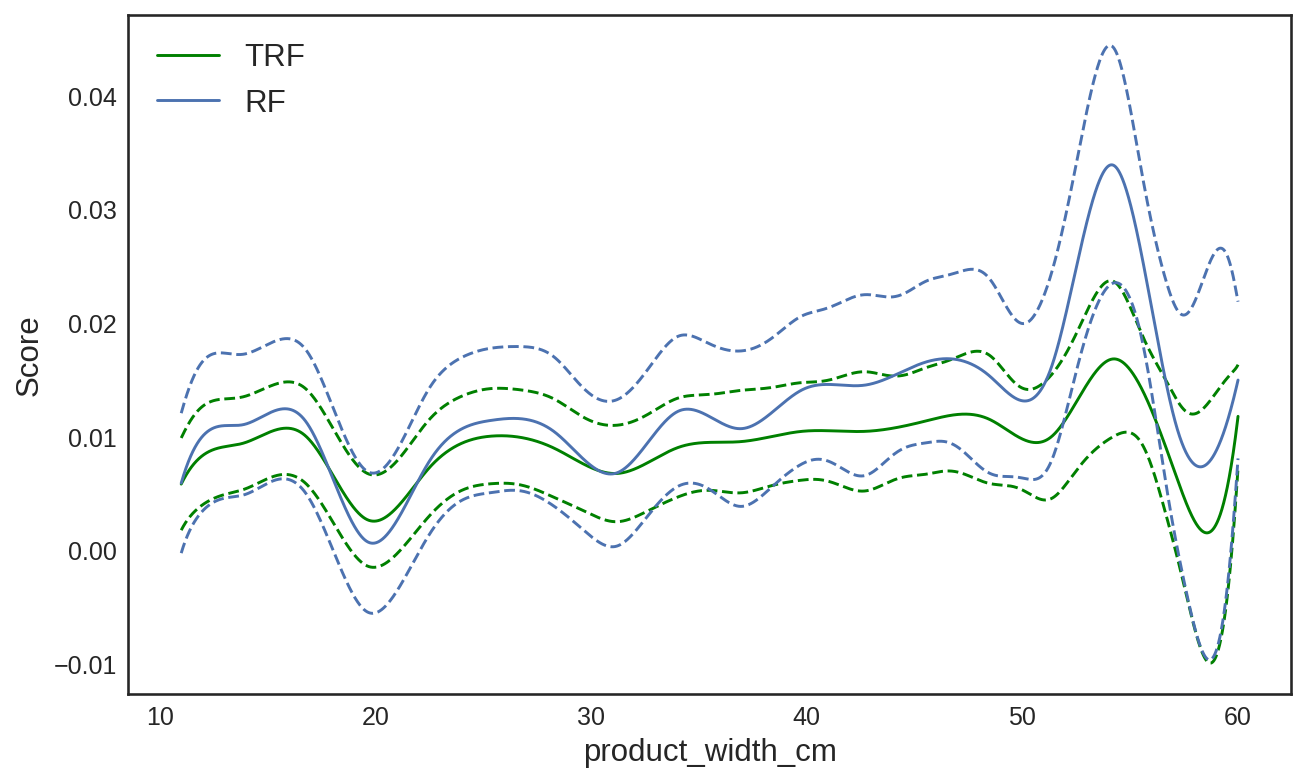

freight_value
12


<Figure size 576x432 with 0 Axes>

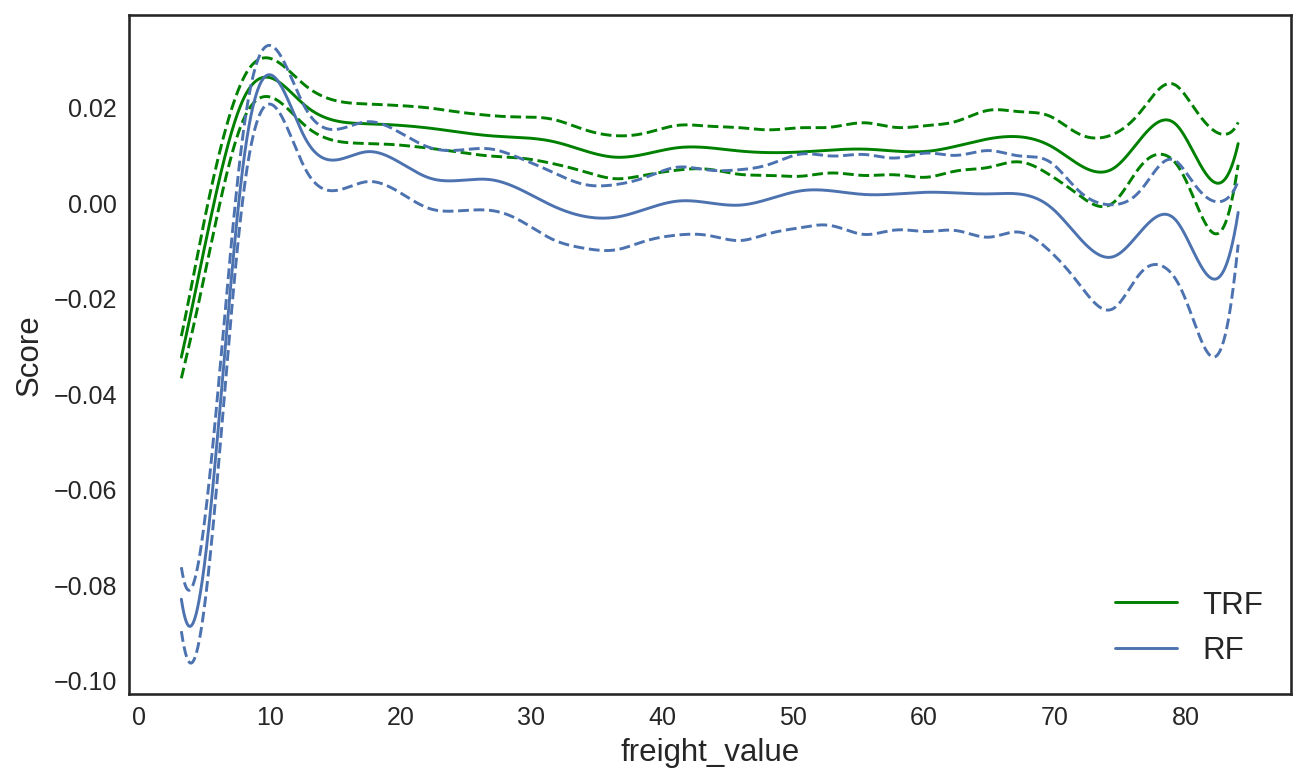

<Figure size 576x432 with 0 Axes>

In [92]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    XX[:, 8] = X_test.values[:, 8]
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

product_category_name


No handles with labels found to put in legend.


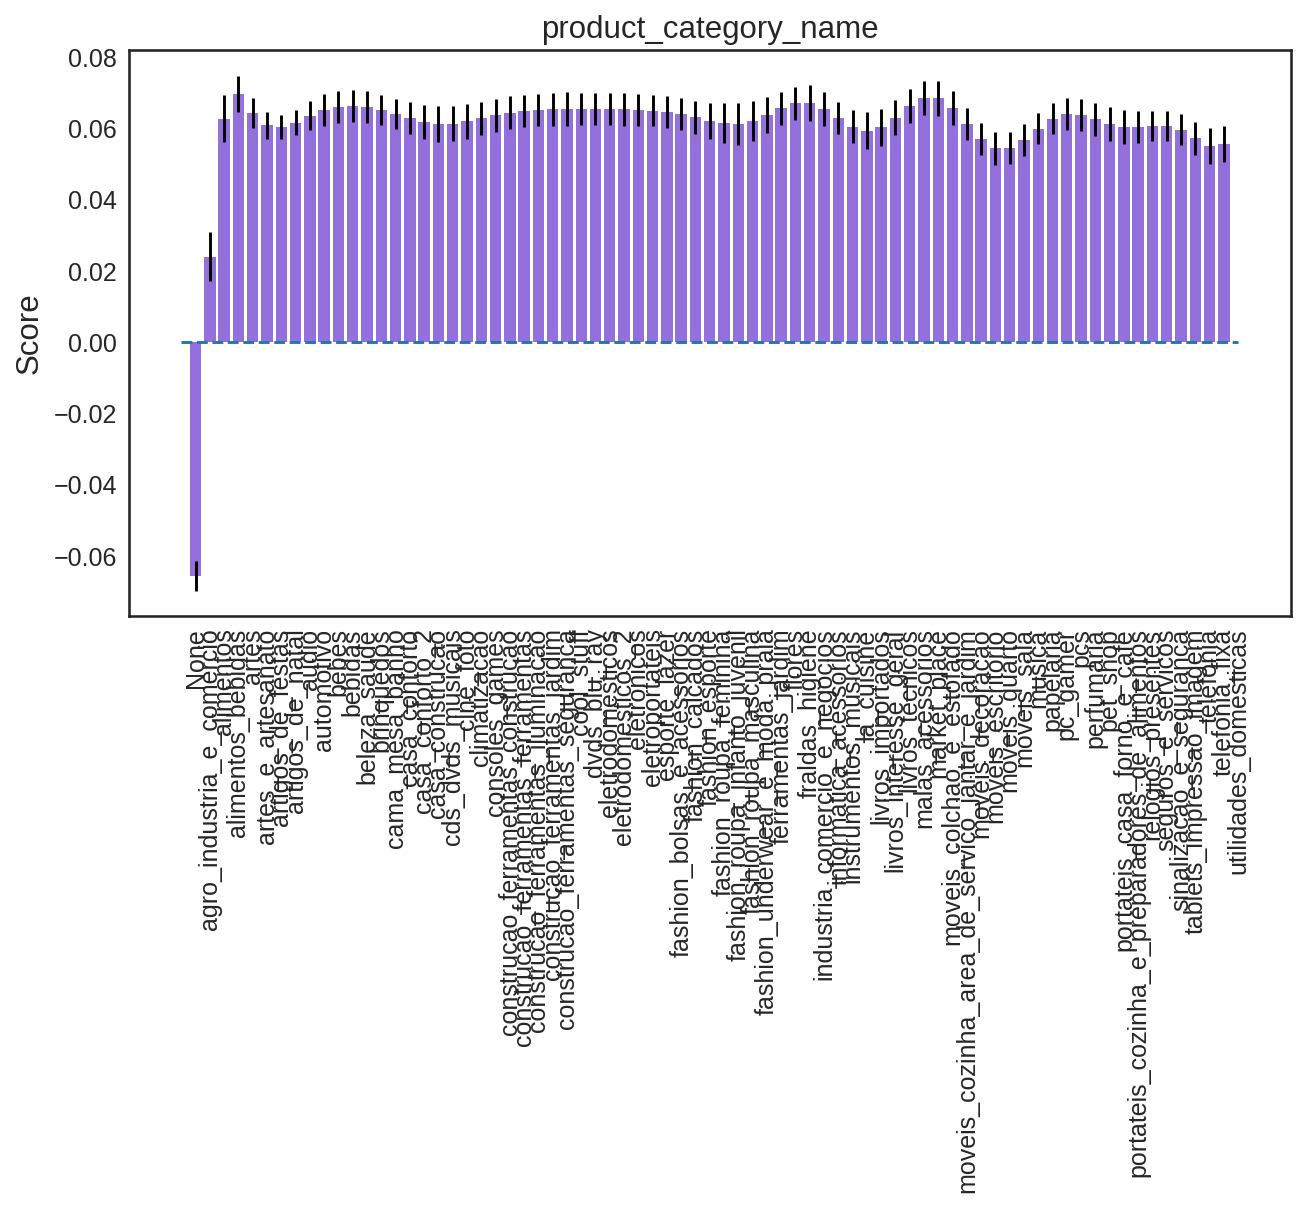

seller_id


<Figure size 576x432 with 0 Axes>

In [93]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        try:
            mapping = encoder_mappings[feat]
            max_cat = np.max(list(mapping.keys()))
            if max_cat > 100:
                continue
            XX = np.copy(X_test)
            XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
            pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
            fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
            data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                                columns=[feat, "Mean Impact", "low", "high"])
            data["low"] = np.abs(data["low"] - data["Mean Impact"])
            data["high"] = np.abs(data["high"] - data["Mean Impact"])
            agg = data.groupby(feat).mean()

            impact_plot = plt.bar([i for i in range(len(agg))],
                                  agg["Mean Impact"],
                                  yerr=agg[["low", "high"]].values.transpose(),
                                  color="#9370DB",
                                  capsize=7)

            plt.title(feat, fontsize=15)
            plt.xticks([i for i in range(len(list(mapping.keys())))])
            ax.set_xticklabels(list(mapping.values()), rotation=90)
            plt.hlines(0.0, -1, max_cat, linestyles="dashed")
            plt.ylabel("Score", fontsize=15)

            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)
            xmin, xmax, ymin, ymax = plt.axis()
            plt.ylim([ymin, ymax])
            plt.legend(fontsize=15)
            plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

            plt.show()
            plt.clf()
        except:
            print("No plot for {}".format(feat))
plt.show()

product_category_name


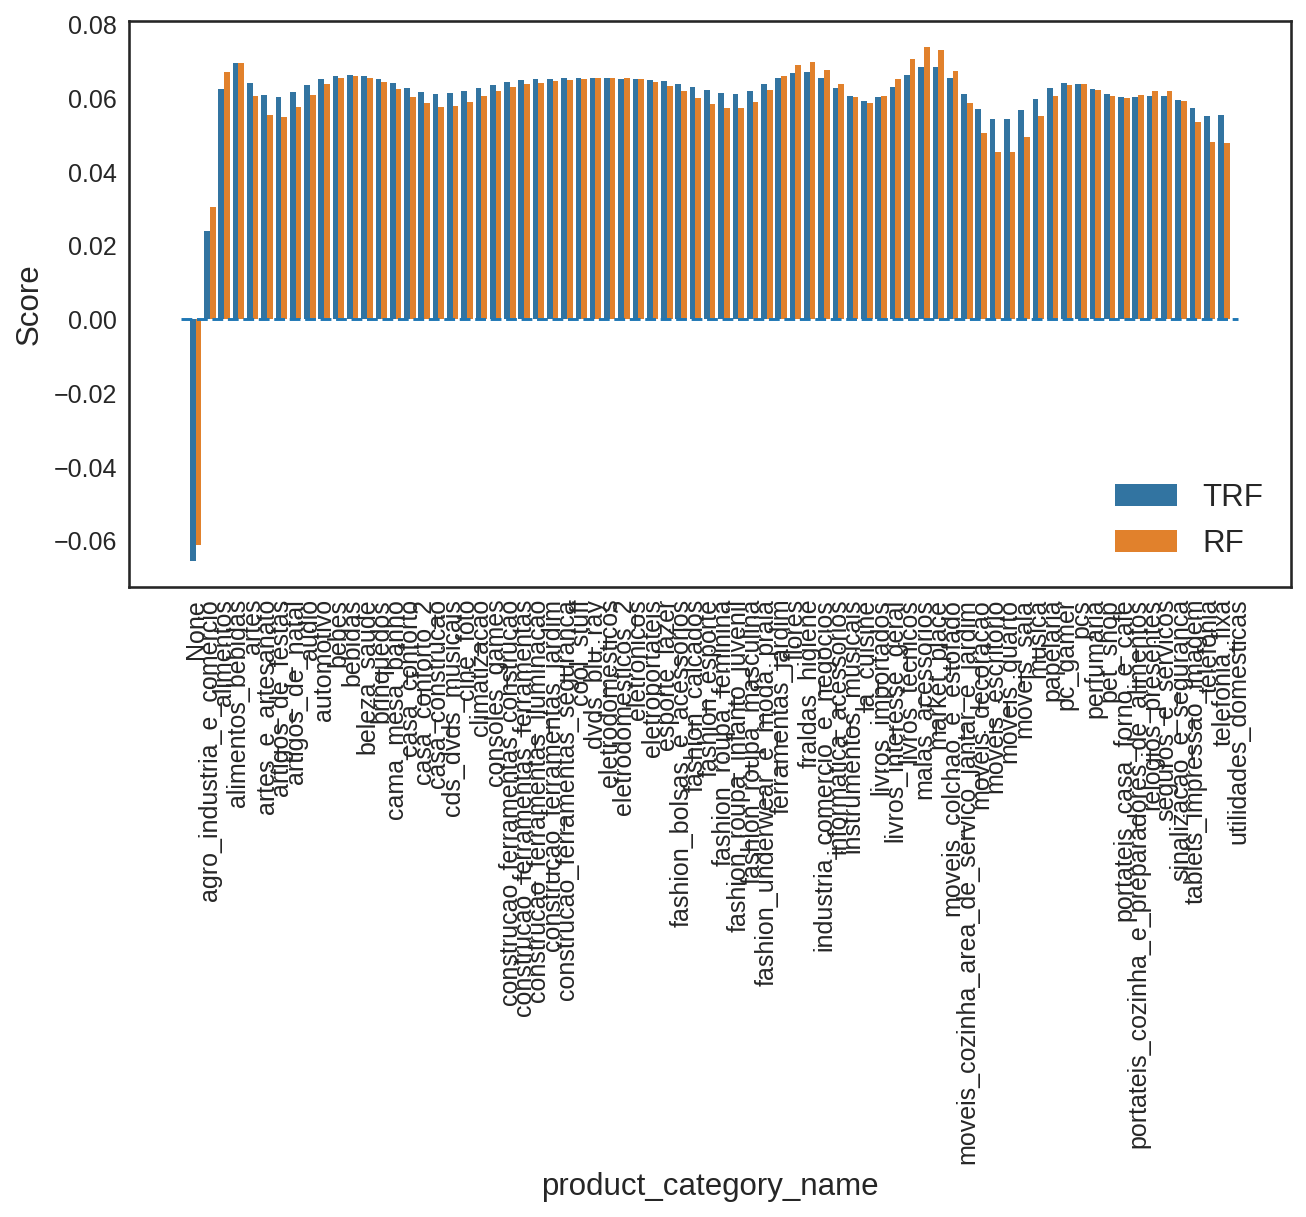

seller_id


<Figure size 576x432 with 0 Axes>

In [94]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [95]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [96]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=min_sample_periods,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

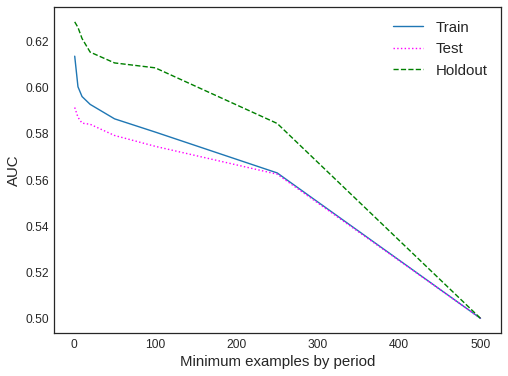

In [97]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

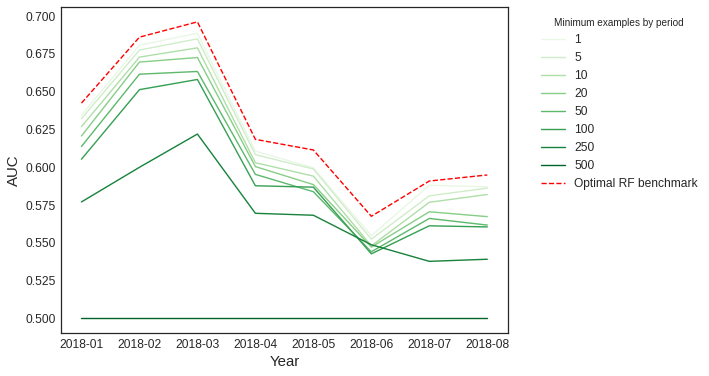

In [99]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [100]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = tuned_rf
    model.set_params(min_samples_leaf=training_segments * min_sample_periods)
    
    
    model.fit(train[features],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

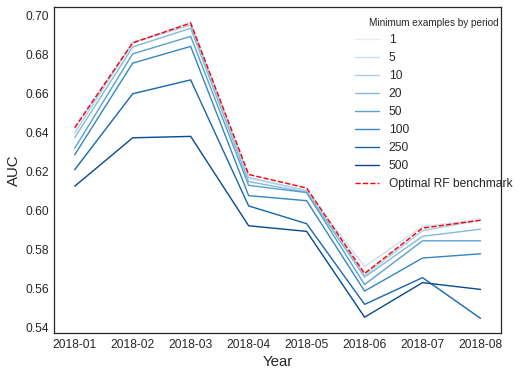

In [102]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

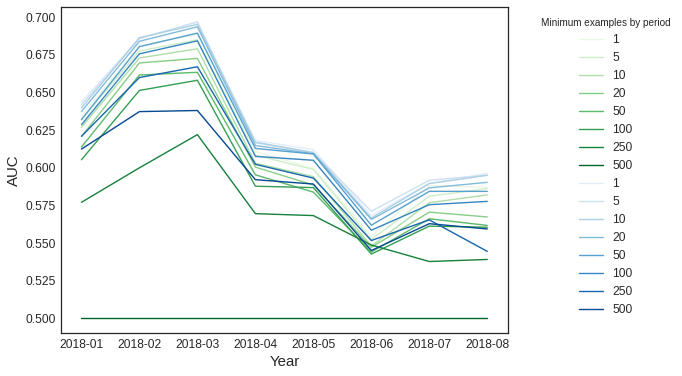

In [103]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
#plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

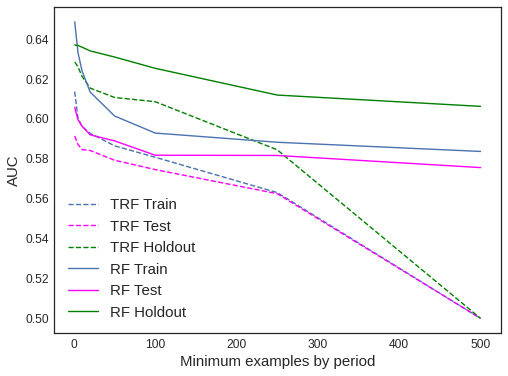

In [104]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

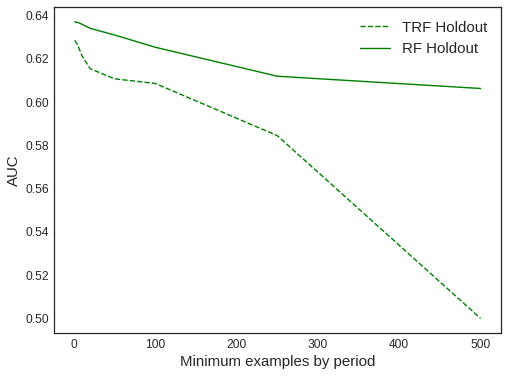

In [105]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [106]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [107]:
domain_data = pd.concat([train, test, out_of_time])

In [108]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [109]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

In [110]:
domain_model = tuned_domain_rf

In [111]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [112]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [113]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.8050442231855911

## Other optimization design for the RF

In [114]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

'2017-12'

In [115]:
posfix = str(last_time_segment_in_train)

In [117]:
new_train = in_time[in_time[TIME_COLUMN] < last_time_segment_in_train]
new_validation = in_time[in_time[TIME_COLUMN] == last_time_segment_in_train]

In [121]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [122]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=-1, oob_score=False, random_state=44, verbose=0,
                       warm_start=False)

In [123]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [124]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [125]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [126]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

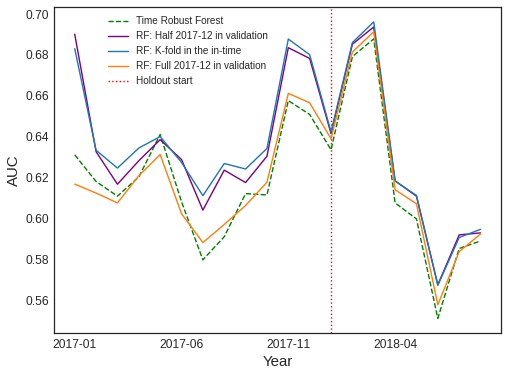

In [150]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(12, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=10, bbox_to_anchor=(0.10, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()
